# Random forest regressor for Insurance data

## 1.Abstract

The aim of the notebook is to predict the insurance charges using Random forest regression model using hyperparamter tuning. The notebook also focuses on model interpretability with SHapley Additive exPlanations to find the factors affecting the insurance charges.

The Root Mean Square Error using Random Forest Regressor for the prediction is 0.08 

From the summary plot, it can be observed that Smoker, age, BMI, number of children are the features that most affecting the charges in the insurance. (assesment) what are plots 


### 2. Import libraries

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import plotly
np.random.seed(0)
import seaborn as sns
import matplotlib.pyplot as plt
import shap

### 3. Data loading and pre-processing

In [53]:
# load the data
data = pd.read_csv('insurance.csv') 
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### 3.1 Encoding 'sex' and 'smoker'

In [54]:
data['sex'] = data.sex.map({'male':0, 'female':1})

data['smoker'] = data.smoker.map({'no':0, 'yes':1})

data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,southwest,16884.92400
1,18,0,33.770,1,0,southeast,1725.55230
2,28,0,33.000,3,0,southeast,4449.46200
3,33,0,22.705,0,0,northwest,21984.47061
4,32,0,28.880,0,0,northwest,3866.85520


In [4]:
# unique 'region' values
data.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

#### 3.2 Creating dummy variables for 'region'

In [55]:
# Create dummy variables for region
df = pd.get_dummies(data['region'])

In [56]:
# Concatenate the two dataframes
data = pd.concat([data, df],axis=1)
data.head()

,age,sex,bmi,children,smoker,region,charges,northeast,northwest,southeast,southwest
0,19,1,27.900,0,1,southwest,16884.92400,0,0,0,1
1,18,0,33.770,1,0,southeast,1725.55230,0,0,1,0
2,28,0,33.000,3,0,southeast,4449.46200,0,0,1,0
3,33,0,22.705,0,0,northwest,21984.47061,0,1,0,0
4,32,0,28.880,0,0,northwest,3866.85520,0,1,0,0


In [57]:
# Drop 'region' column as dummy variables are created for it
data = data.drop('region',axis=1)

In [56]:
data.groupby('smoker', as_index=False)['charges'].mean()

,smoker,charges
0,0,8434.268298
1,1,32050.231832


#### 3.3 Normailze the data

In [8]:
from sklearn import preprocessing

# Create x, where x the 'scores' column's values as floats
x = data[['charges','bmi','age']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
data[['charges','bmi','age']] = pd.DataFrame(x_scaled)

In [9]:
# Looking at the data after normailzing
data.head()

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,0.021739,1,0.321227,0,1,0.251611,0,0,0,1
1,0.000000,0,0.479150,1,0,0.009636,0,0,1,0
2,0.217391,0,0.458434,3,0,0.053115,0,0,1,0
3,0.326087,0,0.181464,0,0,0.333010,0,1,0,0
4,0.304348,0,0.347592,0,0,0.043816,0,1,0,0


In [29]:
#finding the correlation between all the features in the data
data.corr()

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
age,1.000000,0.020856,0.109272,0.042469,-0.025019,0.299008,0.002475,-0.000407,-0.011642,0.010016
sex,0.020856,1.000000,-0.046371,-0.017163,-0.076185,-0.057292,0.002425,0.011156,-0.017117,0.004184
bmi,0.109272,-0.046371,1.000000,0.012759,0.003750,0.198341,-0.138156,-0.135996,0.270025,-0.006205
children,0.042469,-0.017163,0.012759,1.000000,0.007673,0.067998,-0.022808,0.024806,-0.023066,0.021914
smoker,-0.025019,-0.076185,0.003750,0.007673,1.000000,0.787251,0.002811,-0.036945,0.068498,-0.036945
charges,0.299008,-0.057292,0.198341,0.067998,0.787251,1.000000,0.006349,-0.039905,0.073982,-0.043210
northeast,0.002475,0.002425,-0.138156,-0.022808,0.002811,0.006349,1.000000,-0.320177,-0.345561,-0.320177
northwest,-0.000407,0.011156,-0.135996,0.024806,-0.036945,-0.039905,-0.320177,1.000000,-0.346265,-0.320829
southeast,-0.011642,-0.017117,0.270025,-0.023066,0.068498,0.073982,-0.345561,-0.346265,1.000000,-0.346265
southwest,0.010016,0.004184,-0.006205,0.021914,-0.036945,-0.043210,-0.320177,-0.320829,-0.346265,1.000000


### 4. Heatmap

The above correlation between all the features in the data is plotted using heatmap


<AxesSubplot:>

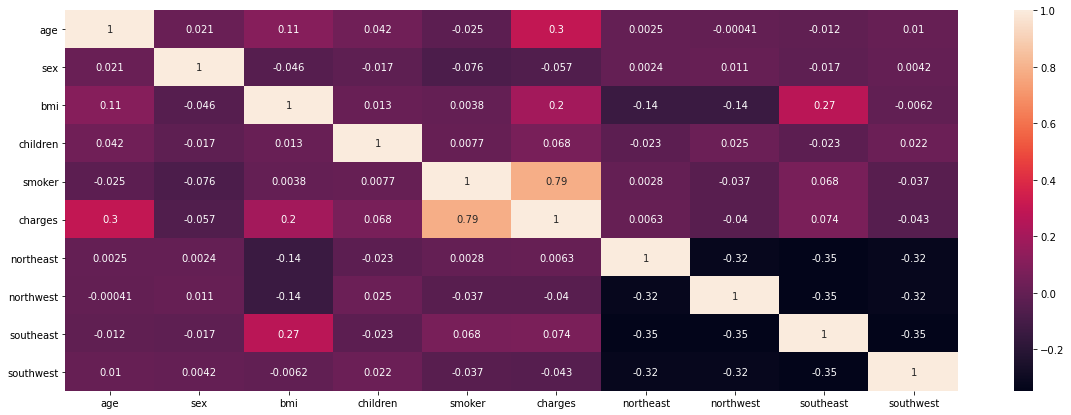

In [11]:
#plotting the heat map of the correlation
plt.figure(figsize=(20,7))
sns.heatmap(data.corr(), annot=True)

### 5. Pair plot
Pait plot gives a relationship between each variable.

<Figure size 864x720 with 0 Axes>

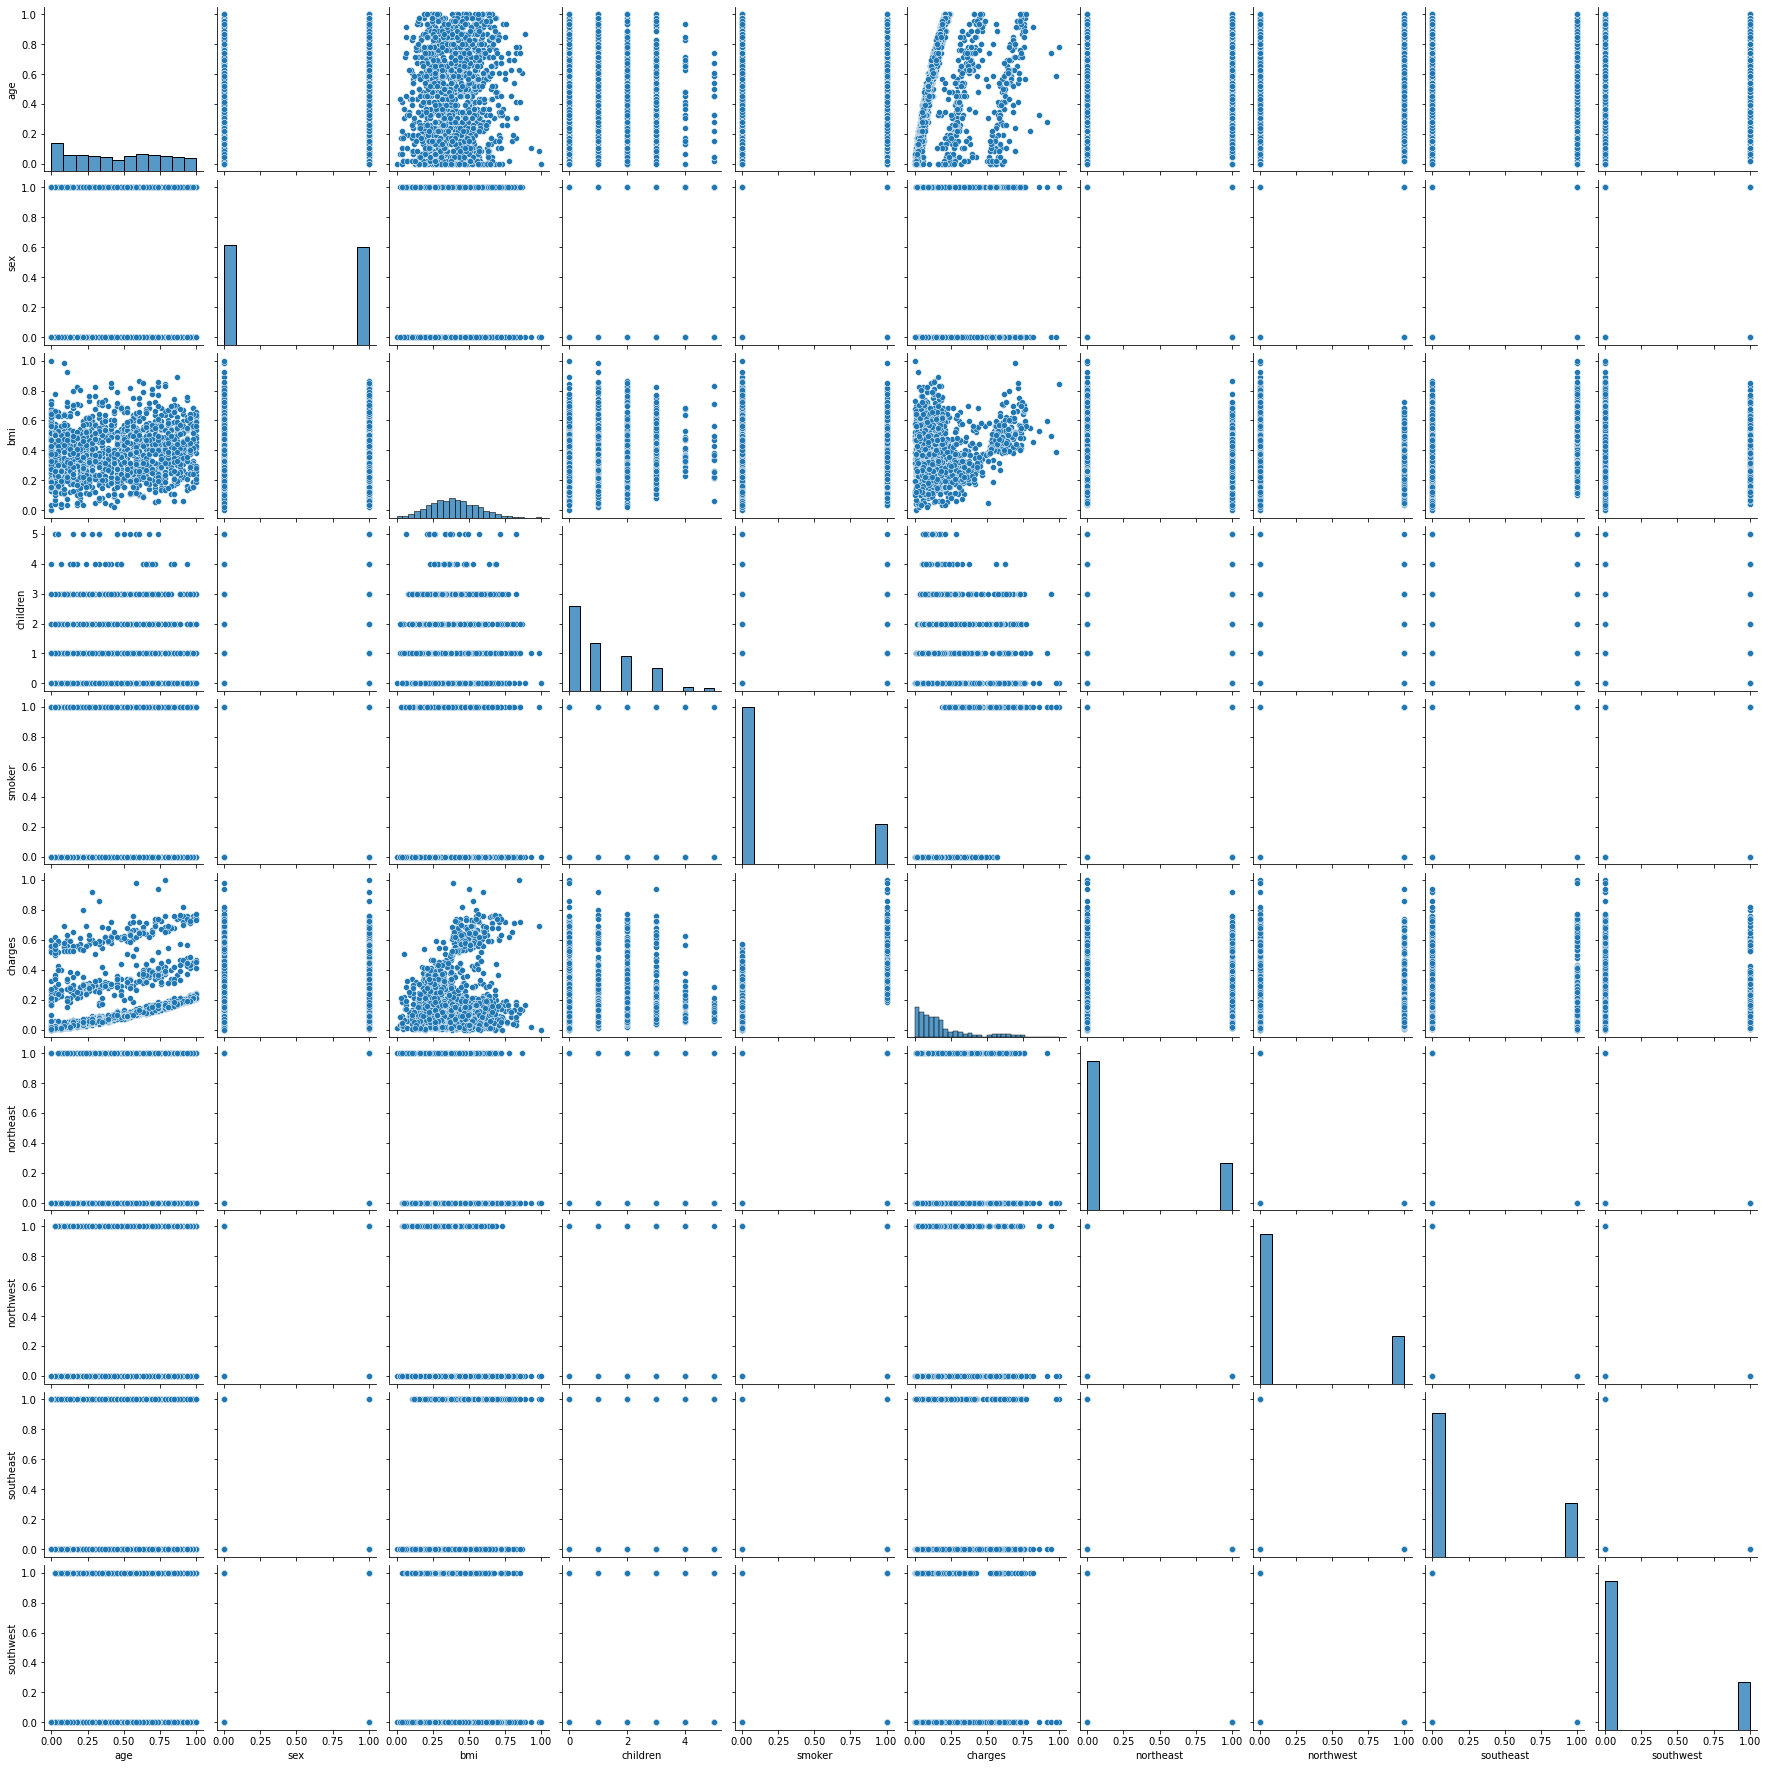

In [12]:
#pair plot
plt.figure(figsize=(12,10))
sns.pairplot(data)

### 6. Ordinary Least Squares
Ordinary Least Squares (OLS) is the most common estimation method for linear models

In [30]:
#Using OLS for finding the p value and f statistics 
import statsmodels.api as sm
import statsmodels.formula.api as smf
model = sm.OLS(data['charges'], data[['age','sex','bmi','children','smoker','northeast',
                                      'northwest','southeast','southwest']]).fit()

# Print out the statistic
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Sat, 13 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:11:22   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          256.8564     11.899     21.587      0.000     233.514     280.199
sex          131.3144    332.945      0.394      0.693    -521.842     784.470
bmi          339.1935     28.599     11.860      0.000     283.088     395.298
children     475.5005    137.804      3.451      0.001     205.163     745.838
smoker      2.385e+04    413.153     57.723      0.000     2.3e+04    2.47e+04
northeast  -1.207e+04    999.649    -12.074      0.000    -1.4e+04   -1.01e+04
northwest  -1.242e+04   1000.681    -12.414      0.000   -1.44e+04   -1.05e+04
southeast   -1.31e+04   1090.510    -12.017      0.000   -1.52e+04    -1.1e+04
southwest  -1.303e+04   1032.967    -12.614      0.000   -1.51e+04    -1.1e+04
==============================================================================
Omnibus:                      300.366   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              718.887
Skew:                           1.211   Prob(JB):                    7.86e-157
Kurtosis:                       5.651   Cond. No.                         613.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Observations:

**For any modelling task, the hypothesis is that there is some correlation between the features and the target. The null hypothesis is therefore the opposite: there is no correlation between the features and the target.
Considering the significance value of 0.05.**

The age feature has the p-value 0.00, which is less and this provides greater evidence against the null hypothesis and it is a significant feature.

The sex feature has the p-value 0.693, which is greater and this provides less evidence against the null hypothesis and it is not a significant feature.

The BMI feature has the p-value 0.00, which is less and this provides greater evidence against the null hypothesis and it is a significant feature.

The children feature has the p-value 0.001, which is less and this provides greater evidence against the null hypothesis and it is a significant feature.

The smoker feature has the p-value 0.000, which is less and this provides greater evidence against the null hypothesis and it is a significant feature.

The northeast feature has the p-value 0.00, which is less and this provides greater evidence against the null hypothesis and it is a significant feature.

The northwest feature has the p-value 0.00, which is less and this provides greater evidence against the null hypothesis and it is a significant feature.

The southeast feature has the p-value 0.00, which is less and this provides greater evidence against the null hypothesis and it is a significant feature.

The southwest feature has the p-value 0.00, which is less and this provides greater evidence against the null hypothesis and it is a significant feature.

### 7. Train, test and validation split¶
Data is split into 3 parts

Taining data set = 80.75%

Validation data set = 14.25%

Test data set = 5%

In [47]:
from sklearn.model_selection import  train_test_split

X = data[['age','bmi','children','smoker','northeast','northwest','southeast','southwest']]

y = data['charges']

X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.05, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.15, random_state=1)

In [63]:
from sklearn.model_selection import  train_test_split

X = data[['smoker','age']]

y = data['charges']

X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.05, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.15, random_state=1)

In [45]:
from sklearn.model_selection import  train_test_split

X_age = data[['age']]

y_age = data['charges']

X_t, X_test, y_t, y_test = train_test_split(X_age, y_age, test_size=0.05, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.15, random_state=1)

In [37]:
from sklearn.model_selection import  train_test_split

X_emp = data[[]]

y_emp = data['charges']

X_em, X_temp, y_em, y_temp = train_test_split(X_emp, y_emp, test_size=0.05, random_state=1)

X_tremp, X_vemp, y_tremp, y_vemp = train_test_split(X_em, y_em, test_size=0.15, random_state=1)

In [ ]:
y = data['charges']

In [50]:
X.head()

,age,bmi,children,smoker,northeast,northwest,southeast,southwest
0,19,27.900,0,1,0,0,0,1
1,18,33.770,1,0,0,0,1,0
2,28,33.000,3,0,0,0,1,0
3,33,22.705,0,0,0,1,0,0
4,32,28.880,0,0,0,1,0,0


### 8. Random forest regressor

In [13]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [14]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [15]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': True}

In [64]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=70, min_samples_split=10, min_samples_leaf= 4,
                              max_features='auto', n_estimators=400, bootstrap = 'True')

# Fit the model
model.fit(X_train, y_train) 

# Predict the model
y_pred = model.predict(X_test)
y_pred

array([ 3830.72112204, 12925.93458398,  9745.17670197, 10266.87730957,
        4330.6286859 , 30893.48903316, 10266.87730957, 11590.31122326,
        6340.96048414, 36249.98034689, 14414.47348815, 12701.03681536,
        8356.17132338,  7066.90431464,  3043.44736912, 11626.41639966,
        6157.93766672,  6633.22497176, 14664.3145722 , 15664.37675353,
       14425.77124026, 28005.32928436,  9576.92307731, 12348.02312424,
        3043.44736912,  7273.68767894,  9873.01100005, 11626.41639966,
        6157.93766672,  5475.96764575, 11590.31122326,  7336.18595252,
       36458.13459721, 26682.47811351, 31101.34846611, 12344.10056992,
       28005.32928436, 21351.46368315, 12708.31918486, 40449.43350991,
        6339.61741087, 12708.31918486, 12348.02312424, 14664.3145722 ,
        4511.4096215 , 14414.47348815,  2430.94451085, 27890.54222542,
        9745.17670197, 12925.93458398, 16827.51391722, 14121.09716792,
        4719.9794639 ,  9851.76759626, 25823.87940078,  5495.84602365,
      

In [65]:
y_pred.mean()

13702.124415236742

In [47]:
y_test.mean() - y_pred[0]

4169.6433003534785

In [50]:
y_test.mean() - y_pred[0]

10040.002001383915

In [31]:
 y_test.mean() - metrics.mean_absolute_error(y_test, y_pred) 

5105.636780413919

In [22]:
X_test.head()

,age
559,19
1087,57
1020,51
460,49
802,21


In [23]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 8805.908327645782
Mean Squared Error: 124840454.19541325
Root Mean Squared Error: 11173.202504000956


In [39]:
y_test

559      1646.42970
1087    11353.22760
1020     8798.59300
460     10381.47870
802      2103.08000
           ...     
1184    18328.23810
875      2690.11380
786     12741.16745
1013     8765.24900
707     10264.44210
Name: charges, Length: 67, dtype: float64

In [62]:
y_test.mean()

13911.545108059701

### 9. Interpretation using Shap values

### Variable Importance Plot — Global Interpretability

In [66]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [35]:
y_pred

array([ 9726.82898452, 17409.61942253, 15226.34027007, 12694.74484667,
        4835.88097599, 10400.85251642, 12694.74484667, 15112.42801708,
       11110.69154782, 16306.68593927, 25386.58853481, 20261.33977676,
       13317.22123115, 12607.02646986,  7367.89135665, 14197.74621106,
       14289.11793045, 11291.96787943, 18202.09509442, 20078.3629118 ,
       18459.31824616,  9033.31875278, 13360.52232212, 15305.11639053,
        7367.89135665,  8640.88360499, 19289.65022996, 14197.74621106,
       14289.11793045,  9033.31875278, 15112.42801708, 11569.78137066,
       16529.0007017 ,  9726.82898452, 14197.74621106, 16529.0007017 ,
        9033.31875278,  4835.88097599, 14557.34717228, 14865.51695991,
        8748.32152283, 14557.34717228, 15305.11639053, 18202.09509442,
       10400.85251642, 25386.58853481,  7964.40312214,  8748.32152283,
       15226.34027007, 17409.61942253, 23094.79382746, 15419.44308133,
       11850.2054705 , 14865.51695991,  7367.89135665,  9828.5732661 ,
      

In [36]:
y_test.mean() - y_pred[0]

4184.716123541903

In [67]:
shap_values

array([[-4686.07751354, -4641.7523562 ],
       [-4924.0445025 ,  4691.4280947 ],
       [-5233.36934063,  1819.99505082],
       [-4492.09799388,  1600.42431168],
       [-4100.51855269, -4727.40375319],
       [20142.8175862 , -2407.87954482],
       [-4492.09799388,  1600.42431168],
       [-5084.67979103,  3516.44002251],
       [-4279.40288536, -2538.18762228],
       [20889.8998931 ,  2201.52946202],
       [-5565.17818682,  6821.1006832 ],
       [-5345.65202788,  4888.13785146],
       [-4094.53938028,  -707.84028811],
       [-4421.03357329, -1670.61310386],
       [-4679.013231  , -5436.09039166],
       [-4346.8055559 ,  2814.67096378],
       [-4845.76231631, -2154.85100875],
       [-4841.08095181, -1684.24506821],
       [-5222.78109987,  6728.54468029],
       [-4608.49541967,  7114.32118142],
       [-4565.94616977,  5833.16641825],
       [18602.91477144, -3756.13647885],
       [-5074.96881416,  1493.34089969],
       [-4697.89075272,  3887.36288519],
       [-4679.01

#### Plot showing average impact on Insurance charges

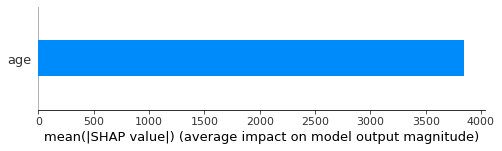

In [25]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

#### Observations:

From this graph it can be observed that Smoker, age, BMI, number of children are most affecting the charges in the insurance.

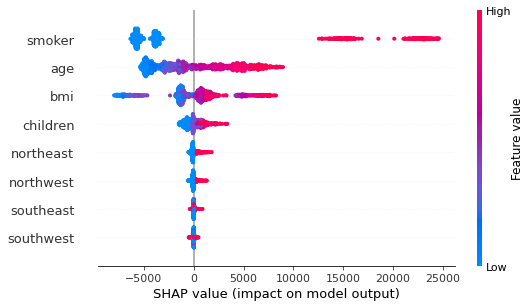

In [36]:
shap.summary_plot(shap_values, X_train)

### Individual SHAP Value Plot — Local Interpretability

#### Force plot

In [37]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

#### Observations for shap_plot(0):

Output value: is the prediction for this observation

Base value: The original paper explains that the base value E(y_hat) is "the value that would be predicted if we did not know any features for the current output." In other words, it is the mean prediction, or mean(yhat). So the mean prediction of Y_test is 0.19.

Features: The above explanation shows features that contributes to push the final prediction away from the base value.

Red/blue: Those features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.

BMI: has a postive impact on the insurance charges. A higher value than the average BMI drives the prediction to the left.

Smoker: has negative impact on the insurance charges. The value of smoker is 0 which is less than the average value 0.20. So it pushes the prediction to the right.

Children: has negative impact on the insurance charges. The value of age is 0 which is less than the average value 1.086. So it pushes the prediction to the right.

Age: has positive impact on the insurance charges. The value of age is 0.021 which is less than the average value 0.45. So it pushes the prediction to the left.

#### Collective force plot

Each observation has its own force plot. If all the force plots are combined, rotated 90 degrees and stacked horizontally, we get the force plot of the entire data

The Y-axis is the X-axis of the individual force plot. There are 1072 data points in X(data), so the X-axis has 1072 observations.

In [38]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

### Summary plot with SHAP values
The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

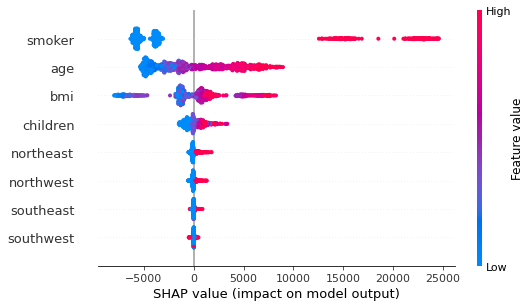

In [39]:
shap.summary_plot(shap_values, X_train)

#### Observations:

Charges of the insurance is associated with the following characteristics:

1. High smoker

2. High age

3. High BMI

4. Higher number of children

5. High for people staying the the northeast region

6. High for people staying the the northwest region

7. Low for the feature sex

8. Low for people staying the the southeast region

9. Low for people staying the the southwest region

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset.

In the summary plot, we see first indications of the relationship between the value of a feature and the impact on the prediction. But to see the exact form of the relationship, we have to look at SHAP dependence plots.

### Dependence plot

SHAP feature dependence might be the simplest global interpretation plot: 1) Pick a feature. 2) For each data instance, plot a point with the feature value on the x-axis and the corresponding Shapley value on the y-axis. 3) Done.

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


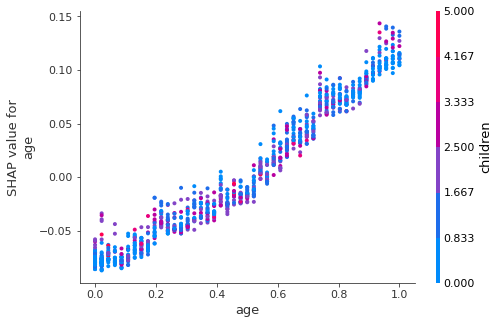

In [25]:
# the interaction is really in the model see SHAP interaction values below
shap.dependence_plot("age", shap_values, X_train)

#### Observations:
 The following plot shows there is an approximately linear and positive trend between “age” and the target variable, and “age” interacts with “children” frequently.

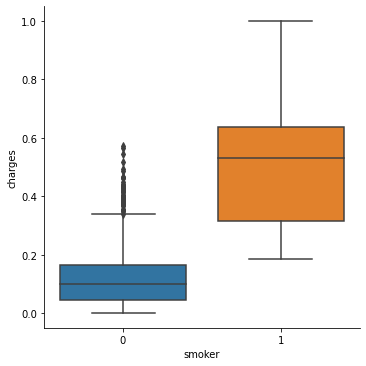

In [26]:
sns.catplot(x="smoker", y="charges", kind='box', data=data)

#### Observations:

From this graph it can be observed that people who do not smoke (smoke no = 0) pay less insurance whereas people who do smoke (smoke yes = 1) pay more insurance.

### 10. Conclusion
The random forest regressor model is trained and interpreted based on feature importance.

Using Variable Importance Plot, it can be observed that smoker feature is affecting the most to target output. The feature age, BMI and children also affect the target output

### 11. Refrence

1. https://shap.readthedocs.io/en/latest/tabular_examples.html
2. https://www150.statcan.gc.ca/n1/edu/power-pouvoir/ch12/5214889-eng.html
3. https://www.geeksforgeeks.org/random-forest-regression-in-python/

Copyright 2020 Pranatha Rajaprasad Rao

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.